In [97]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy as sp
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy import signal, stats

# Gridded data

In [2]:
land = xr.open_dataset("./../co2_temp_data/temp/CRUTEM.4.6.0.0.anomalies.nc")
ocean = xr.open_dataset("./../co2_temp_data/temp/HadSST.3.1.1.0.median.nc")

In [3]:
land

<xarray.Dataset>
Dimensions:              (latitude: 36, longitude: 72, time: 2039)
Coordinates:
  * latitude             (latitude) float32 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude            (longitude) float32 -177.5 -172.5 ... 172.5 177.5
  * time                 (time) datetime64[ns] 1850-01-16T12:00:00 ... 2019-11-16
Data variables:
    temperature_anomaly  (time, latitude, longitude) float32 ...
    field_status         (time) |S1 ...
Attributes:
    title:        CRUTEM4 temperature anomalies
    institution:  Climatic Research Unit, University of East Anglia/Met Offic...
    history:      
    source:       
    comment:      
    reference:    Jones, P. D., D. H. Lister, T. J. Osborn, C. Harpham, M. Sa...
    version:      CRUTEM.4.6.0.0
    Conventions:  CF-1.0

In [4]:
ocean

<xarray.Dataset>
Dimensions:       (latitude: 36, longitude: 72, nv: 2, time: 2039)
Coordinates:
  * time          (time) datetime64[ns] 1850-01-16T11:59:59.505615234 ... 2019-11-16
  * latitude      (latitude) float32 87.5 82.5 77.5 72.5 ... -77.5 -82.5 -87.5
  * longitude     (longitude) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
Dimensions without coordinates: nv
Data variables:
    time_bnds     (time, nv) float32 ...
    field_status  (time) |S1 ...
    sst           (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly 5 degree version of HadSST.3.1.1.0 - ...
    source:                     HadSST.3.1.1.0
    reference:                  Kennedy J.J., Rayner, N.A., Smith, R.O., Saun...
    Conventions:                CF-1.0
    history:                    10/12/2019 converted to netcdf
    supplementary_information:  Updates and supplementary information are ava...
    ensemble_members:           100

In [5]:
land.temperature_anomaly.sel(time="2012-04")

<xarray.DataArray 'temperature_anomaly' (time: 1, latitude: 36, longitude: 72)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * longitude  (longitude) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * time       (time) datetime64[ns] 2012-04-16
Attributes:
    long_name:         temperature_anomaly
    units:             K
    reference_period:  [1961 1990]

In [6]:
def plot_land(data):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.contourf(land.longitude, land.latitude, data)
    
def plot_ocean(data):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.contourf(ocean.longitude, ocean.latitude, data)

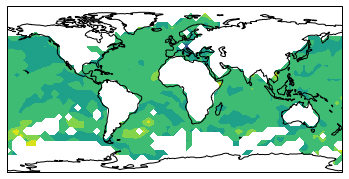

In [7]:
data_ocean = ocean.sst.sel(time="2002-01").values.squeeze()
plot_ocean(data_ocean)

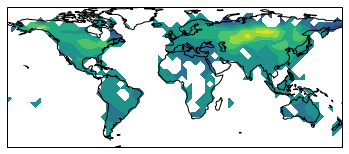

In [8]:
data_land = land.temperature_anomaly.sel(time="2002-01").values.squeeze()
plot_land(data_land)

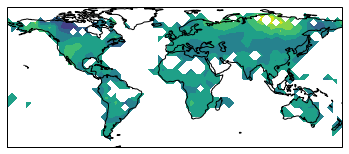

In [9]:
plot_land(land.temperature_anomaly.sel(time="1959-06").values.squeeze())

## Aggregating spatially into regions

Regions are:
- 90N to 23N
- 23N to 23S
- 23S to 90S

In [10]:
land.temperature_anomaly

<xarray.DataArray 'temperature_anomaly' (time: 2039, latitude: 36, longitude: 72)>
[5285088 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * longitude  (longitude) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2019-11-16
Attributes:
    long_name:         temperature_anomaly
    units:             K
    reference_period:  [1961 1990]

In [11]:
p=np.array([[1,2,3], [4,3,1], [9,2,3]])
p

array([[1, 2, 3],
       [4, 3, 1],
       [9, 2, 3]])

In [12]:
np.average(p)

3.111111111111111

In [13]:
weights=np.array([[1,1,1], [2,2,2], [1,1,1]])

In [14]:
np.average(p, weights=weights)

3.0

In [15]:
lat = land.latitude
lon = land.longitude

In [16]:
from numpy import pi
r_earth = 6.371e6 # Radius of Earth
dtor = pi/180. # conversion from degrees to radians.

def scalar_earth_area(minlat, maxlat, minlon, maxlon):
    """Returns the area of earth in the defined grid box."""
    
    diff_lon = np.unwrap((minlon,maxlon), discont=360.+1e-6)
    
    return 2.*pi*r_earth**2 *(np.sin( dtor*maxlat) - np.sin(dtor*minlat))*(diff_lon[1]-diff_lon[0])/360.


def earth_area(minlat, maxlat, minlon, maxlon):
    """Returns grid of areas with shape=(minlon, minlat) and earth area."""
    
    result = np.zeros((np.array(minlon).size, np.array(minlat).size))
    diffsinlat = 2.*pi*r_earth**2 *(np.sin(dtor*maxlat) - np.sin(dtor*minlat))
    diff_lon = np.unwrap((minlon,maxlon), discont=360.+1e-6)
    
    for i in range(np.array(minlon).size):
        result[i, :] = diffsinlat *(diff_lon[1,i]-diff_lon[0,i])/360.
    
    return result

def earth_area_grid(lats,lons):
    """Returns an array of the areas of each grid box within a defined set of lats and lons."""
    
    result=np.zeros((lats.size, lons.size))
    
    minlats = lats - 0.5*(lats[1]-lats[0])
    maxlats= lats + 0.5*(lats[1]-lats[0])
    minlons = lons - 0.5*(lons[1]-lons[0])
    maxlons=lons + 0.5*(lons[1]-lons[0])
    
    for i in range(lats.size):
        result[i,:] = scalar_earth_area(minlats[i],maxlats[i],minlons[0],maxlons[0])
    
    return result

In [35]:
weights = earth_area_grid(lat,lon)
weights

array([[1.34788146e+10, 1.34788146e+10, 1.34788146e+10, ...,
        1.34788146e+10, 1.34788146e+10, 1.34788146e+10],
       [4.03338620e+10, 4.03338620e+10, 4.03338620e+10, ...,
        4.03338620e+10, 4.03338620e+10, 4.03338620e+10],
       [6.68819443e+10, 6.68819443e+10, 6.68819443e+10, ...,
        6.68819443e+10, 6.68819443e+10, 6.68819443e+10],
       ...,
       [6.68819443e+10, 6.68819443e+10, 6.68819443e+10, ...,
        6.68819443e+10, 6.68819443e+10, 6.68819443e+10],
       [4.03338620e+10, 4.03338620e+10, 4.03338620e+10, ...,
        4.03338620e+10, 4.03338620e+10, 4.03338620e+10],
       [1.34788146e+10, 1.34788146e+10, 1.34788146e+10, ...,
        1.34788146e+10, 1.34788146e+10, 1.34788146e+10]])

In [36]:
data = land.temperature_anomaly.sel(time="1959-06").values.squeeze()
data

array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ..., -0.55,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]], dtype=float32)

In [37]:
data[np.isnan(data)] = 0
weights[np.isnan(data)] = 0
result = np.average(data, axis=1, weights=weights)
result

array([-0.025     ,  0.        , -0.14652778,  0.02222222, -0.02638889,
       -0.075     , -0.00555556, -0.0125    ,  0.00868056, -0.00089922,
       -0.03603901,  0.01155622,  0.09141174,  0.09613426,  0.03462301,
        0.09502315,  0.01446759, -0.02085438,  0.02368056,  0.03338459,
        0.05168607,  0.09868078,  0.07399627, -0.01662536,  0.05119143,
       -0.04575018, -0.12222074, -0.13192016,  0.10673726,  0.31898294,
        0.29520954,  0.43775971,  0.52622685,  0.22847222,  0.02638889,
        0.        ])

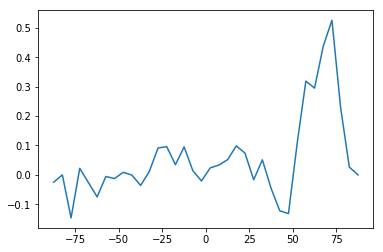

In [38]:
plt.plot(lat, result)

In [49]:
np.average(result[lat<-23])

-0.014926131393832084

In [115]:
np.average(result[(lat<23) & (lat>-23)])

0.05008218970356715

In [63]:
np.average(result[lat>23])

0.1288040317983056

Further work to be done here when we need regional averaged temperature on monthly and yearly scales.<br/>
However, the NH and SH regional datasets provided online are available and may be sufficient. Most likely we will need to perform the spatial aggregations if we specifically need 23-90N, 23S-23N and 23S-90S.

For the global analyses, the monthly and annual global values supplied and shown below are sufficient.

# Monthly global

- CRUTEM4 is land (air temp. anomalies on a 5deg by 5deg grid).
- HadSST3 is ocean (sst anomalies on a 5deg by 5deg grid).
- HADCRUT4 is combined land and ocean (CRUTEM4 and HadSST3).

In [64]:
#HADCRUT4
monthly = pd.read_csv("./../co2_temp_data/temp/HADCRUT4_annual.txt",
            delim_whitespace=True,
            header=0,
            index_col=0,
            usecols=([0,1,2,3,4,5,6,7,8,9,10,11,12])
           )
monthly.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1959,0.087,0.033,0.079,0.046,-0.010,0.062,0.030,0.047,0.041,-0.034,-0.111,-0.069
1960,-0.032,0.104,-0.314,-0.176,-0.156,-0.030,-0.028,0.008,0.064,-0.027,-0.149,0.146
1961,0.045,0.177,0.093,0.096,0.092,0.111,0.019,0.033,-0.029,-0.033,-0.018,-0.117
1962,0.053,0.135,0.028,0.024,-0.047,-0.052,0.018,-0.005,-0.017,0.042,0.010,-0.012
1963,-0.045,0.148,-0.147,-0.069,-0.022,-0.033,0.111,0.126,0.127,0.225,0.164,-0.006


In [65]:
vals = []
for i in range(60):
    for j in monthly.iloc[i]:
        vals.append(j)
monthly = pd.DataFrame({"Temp.": vals},
            index=np.arange(1959,2019,1./12))

In [66]:
monthly

,Temp.
1959.000000,0.087
1959.083333,0.033
1959.166667,0.079
1959.250000,0.046
1959.333333,-0.010
...,...
2018.583333,0.586
2018.666667,0.598
2018.750000,0.678
2018.833333,0.590


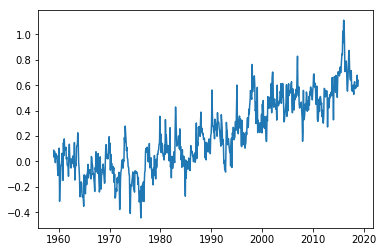

In [67]:
plt.plot(monthly)

## Frequency analysis

In [68]:
def psd(df, **kwargs):
    x = df.index
    y = df.values.squeeze()
    
    freqs, X = signal.welch(y, **kwargs)
    
    plt.figure(figsize=(22,10))
    
    plt.subplot(211)
    plt.semilogy(1/freqs, X)
    plt.title("Power Spectrum", fontsize=28)
    plt.gca().invert_xaxis()
    plt.xlabel("Period (years)", fontsize=20)
    plt.ylabel("Spectral Variance ($^\circ$C$^2$.yr)", fontsize=20)

    plt.subplot(212)
    plt.plot(x,y)
    
    return pd.DataFrame({"Period (Years)": 1/freqs, "Spectral Variance": X}, index=freqs)

/home/student.unimelb.edu.au/rursino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/student.unimelb.edu.au/rursino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


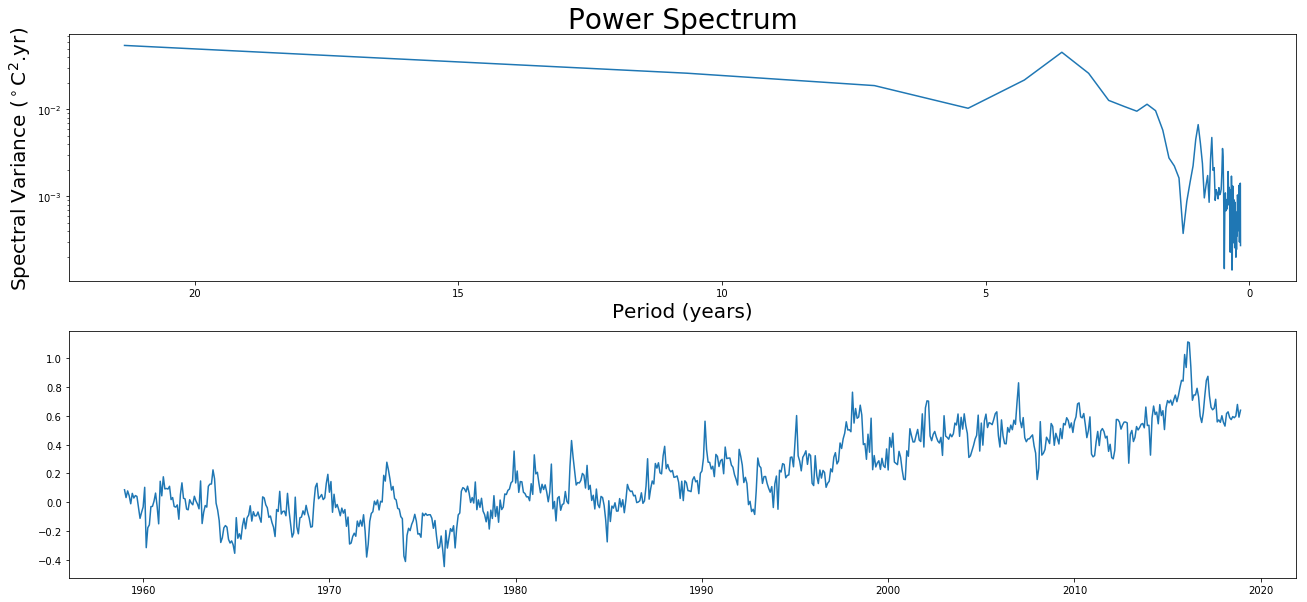

In [69]:
monthly_psd = psd(monthly, fs=12)

In [70]:
print(str(1/monthly_psd["Spectral Variance"].idxmax()))
print(str(monthly_psd["Spectral Variance"].max()))

21.333333333333332
0.05435962194292293


In [71]:
monthly_psd.iloc[3:8]

,Period (Years),Spectral Variance
0.140625,7.111111,0.018781
0.187500,5.333333,0.010308
0.234375,4.266667,0.021766
0.281250,3.555556,0.045374
0.328125,3.047619,0.026016


# Annual

In [72]:
annual = pd.read_csv("./../co2_temp_data/temp/HADCRUT4_annual.txt",
            delim_whitespace=True,
            header=0,
            index_col=0,
            usecols=([0,13])
           )
annual.head()

,Ann
Year,
1959,0.017
1960,-0.049
1961,0.038
1962,0.014
1963,0.048


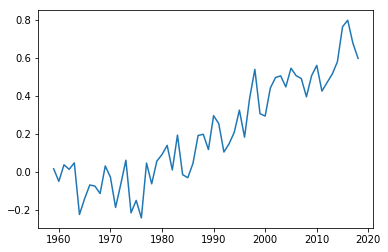

In [73]:
plt.plot(annual)

/home/student.unimelb.edu.au/rursino/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 60, using nperseg = 60
  .format(nperseg, input_length))
/home/student.unimelb.edu.au/rursino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/student.unimelb.edu.au/rursino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


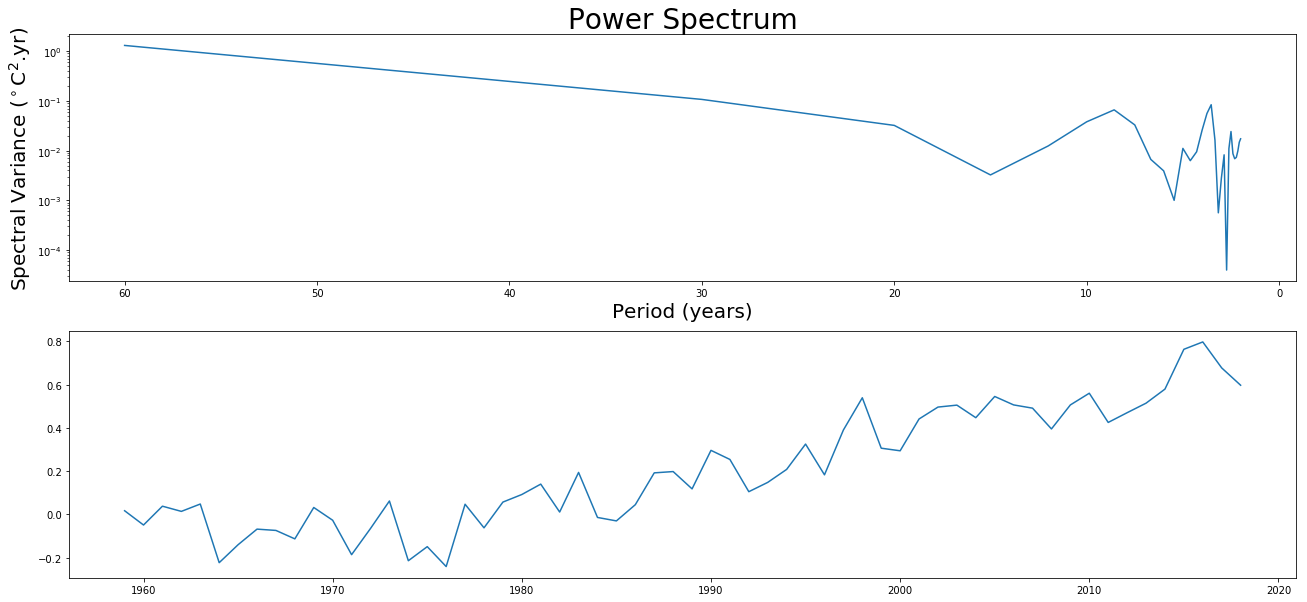

In [74]:
psd_annual = psd(annual, fs=1)

In [75]:
psd_annual

,Period (Years),Spectral Variance
0.000000,inf,0.027681
0.016667,60.000000,1.299982
0.033333,30.000000,0.107046
0.050000,20.000000,0.032173
0.066667,15.000000,0.003255
0.083333,12.000000,0.012434
0.100000,10.000000,0.037981
0.116667,8.571429,0.066014
0.133333,7.500000,0.032880
0.150000,6.666667,0.006668


In [76]:
a1 = annual["Ann"].autocorr(lag=1)

In [77]:
var_annual = np.var(annual.Ann)

In [78]:
var_noise = (1-a1**2)*var_annual

In [79]:
psd_AR1 = var_noise/(1+a1**2-2*a1*np.cos(2*np.pi*psd_annual.index))

In [80]:
len(psd_AR1)

31

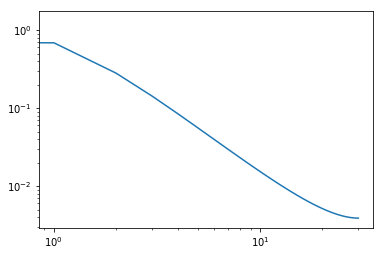

In [81]:
plt.loglog(psd_AR1)

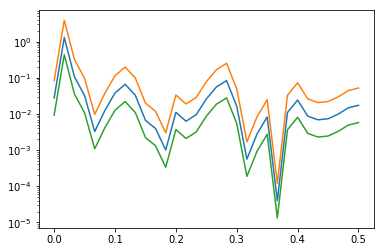

In [82]:
plt.semilogy(psd_annual.index, psd_annual["Spectral Variance"])
plt.semilogy(psd_annual.index, 3*psd_annual["Spectral Variance"])
plt.semilogy(psd_annual.index, 1/3*psd_annual["Spectral Variance"])

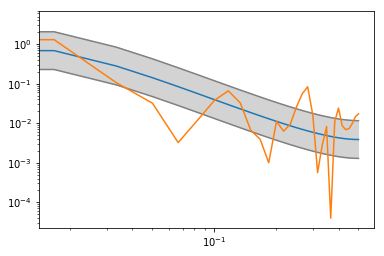

In [83]:
plt.loglog(psd_annual.index, psd_AR1)
plt.loglog(psd_annual.index, 3 * psd_AR1, color='grey')
plt.loglog(psd_annual.index, 1/3 * psd_AR1, color='grey')
plt.fill_between(psd_annual.index, 1./3 * psd_AR1, 3 * psd_AR1, color='lightgrey')

plt.semilogy(psd_annual.index, psd_annual["Spectral Variance"])

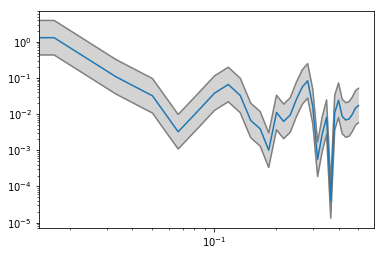

In [84]:
# plt.loglog(psd_annual.index, psd_AR1)

plt.loglog(psd_annual.index, 1./3 * psd_annual["Spectral Variance"], color = 'grey')
plt.loglog(psd_annual.index, 3 * psd_annual["Spectral Variance"], color = 'grey')
plt.fill_between(psd_annual.index, 1./3 * psd_annual["Spectral Variance"], 3 * psd_annual["Spectral Variance"], color='lightgrey')
plt.loglog(psd_annual.index, psd_annual["Spectral Variance"])

In [263]:
psd_annual[(psd_annual["Spectral Variance"] > 3 * psd_AR1)]

,Period (Years),Spectral Variance
0.250000,4.000000,0.025891
0.266667,3.750000,0.055788
0.283333,3.529412,0.083714
0.400000,2.500000,0.024223
0.483333,2.068966,0.014780
0.500000,2.000000,0.017299


In [269]:
psd_annual[(psd_annual["Spectral Variance"] > 3 * psd_AR1)]["Spectral Variance"]- (3*psd_AR1)[(psd_annual["Spectral Variance"] > 3 * psd_AR1)]

0.250000    0.002672
0.266667    0.034754
0.283333    0.064473
0.400000    0.011354
0.483333    0.003104
0.500000    0.005655
dtype: float64

In [264]:
(psd_annual["Spectral Variance"] > 3 * psd_AR1)

0.000000    False
0.016667    False
0.033333    False
0.050000    False
0.066667    False
0.083333    False
0.100000    False
0.116667    False
0.133333    False
0.150000    False
0.166667    False
0.183333    False
0.200000    False
0.216667    False
0.233333    False
0.250000     True
0.266667     True
0.283333     True
0.300000    False
0.316667    False
0.333333    False
0.350000    False
0.366667    False
0.383333    False
0.400000     True
0.416667    False
0.433333    False
0.450000    False
0.466667    False
0.483333     True
0.500000     True
dtype: bool

In [270]:
1 - 0.95**len(psd_annual)

0.7960931742542097